<a href="https://colab.research.google.com/github/tasneemyo/Computer-Vision-Labs/blob/main/Assignment04/mobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files : /kaggle/input/pets-facial-expression-dataset


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


class labels: ['Angry', 'Other', 'Sad', 'happy']
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3])
Epoch 5/10 | LR: 0.001 | Loss: 1.2873
Epoch 10/10 | LR: 0.001 | Loss: 1.2180
Validation Accuracy = 19.44%
Accuracy: 0.3158
Precision: 0.2847
Recall: 0.3621
F1-score: 0.2778

Confusion Matrix:
 [[6 2 0 2]
 [2 4 0 0]
 [4 4 2 1]
 [5 4 2 0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.60      0.44        10
           1       0.29      0.67      0.40         6
           2       0.50      0.18      0.27        11
           3       0.00      0.00      0.00        11

    accuracy                           0.32        38
   macro avg       0.28      0.36      0.28        38
weighted avg       0.28      0.32      0.26        38



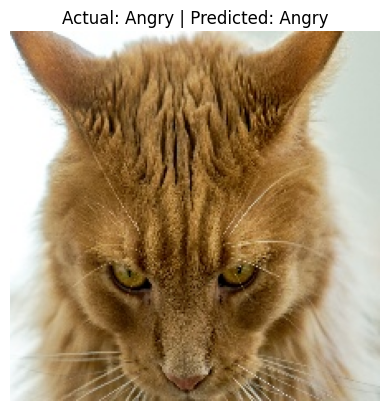

In [ ]:
from google.colab import files
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torchvision.transforms.functional import to_pil_image
import kagglehub

# Download dataset
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")
print("Path to dataset files :",path)
data_path = path + "/Master Folder"

# Transforms
train_transforms = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Datasets and loaders
train_dataset = datasets.ImageFolder(root=f"{data_path}/train", transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=f"{data_path}/valid", transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=f"{data_path}/test", transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

len(train_dataset), len(valid_dataset), len(test_dataset)

print("class labels:",train_dataset.classes)


images, labels = next(iter(test_loader))
print(images.shape)
print(images[0].shape)
print(labels)

np.max(np.array(images[0]))

class_names = train_dataset.classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train(lrs,epochs,train_loader,valid_loader,model_name,device):
  loss_function = nn.CrossEntropyLoss()
  losses=[]
  models=[]
  accuracies=[]
  best_epoch=0
  best_lr=0
  best_accuracy=0
  best_model=None
  #print(lrs,epochs)
  for lr in lrs:
    #print("ana hena")
    for epoch in epochs:
        #print(lrs,epochs)
        print(f"Training with Learning Rate = {lr} and Epochs = {epoch}")
        if model_name == "mobilenet":
          model = get_mobilenet_model(num_classes=4).to(device)
        else :
          model=InceptionV3().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        run_loss = []

        for e in range(epoch):
            training_loss = 0.0
            for i, data in enumerate(train_loader):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()  # Reset the grads
                outputs = model(images)  # Forward pass
                loss = loss_function(outputs, labels)
                training_loss += loss.item()
                loss.backward()  # Backpropagation
                optimizer.step()
                run_loss.append(loss.item())

            if (e + 1) % 10 == 0:
                print(f"Epoch = {e+1}/{epoch} | Learning Rate = {lr} | Loss = {training_loss/len(train_loader):.4f}")

                # --- Save checkpoint every 10 epochs ---
                # checkpoint_path = f"checkpoints/{model_name}_lr{lr}_epoch{e+1}.pt"
                # torch.save({
                #     'epoch': e + 1,
                #     'model_state_dict': model.state_dict(),
                #     'optimizer_state_dict': optimizer.state_dict(),
                #     'loss': training_loss,
                # }, checkpoint_path)
                # print(f"Checkpoint saved: {checkpoint_path}")

        losses.append(run_loss)
        #models.append(model)

        # Evaluate each network on the Validation set
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f"Validation Accuracy = {accuracy:.2f}%")

        model.train()  # Return model to training mode
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lr = lr
            best_epoch = epoch
            best_model_state = model.state_dict()
            best_model=model
        #print(lrs,epochs)


  return best_model,losses,accuracies

def plot_loss(loss,length,accuracies):
# Convert batch-level loss into epoch-level average loss
  epoch_losses = [
      sum(loss[i * length : (i + 1) * length]) / length
      for i in range(len(loss) // length)
  ]
  plt.figure(figsize=(10, 5))
  plt.plot(range(len(epoch_losses)), epoch_losses, label='Training Loss')
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.title(f"Training Loss for Best Model (Accuracy: {accuracies[best_index]:.2f}%)")
  plt.legend()
  plt.grid(True)
  plt.show()


def test(model,test_loader,device):
  preds=[]
  new_labels=[]
  with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        new_labels.extend(labels.cpu().numpy())
    return new_labels,preds

def metrics(model,labels,preds):
  acc = accuracy_score(labels, preds)

  # Precision, Recall, F1-score
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  f1 = f1_score(labels, preds, average='macro')

  # Confusion Matrix
  cm = confusion_matrix(labels, preds)

  # Full classification report
  report = classification_report(labels, preds)

  # Print
  print(f"Accuracy: {acc:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1:.4f}")
  print("\nConfusion Matrix:")
  print(cm)
  print("\nClassification Report:\n", report)

def test_images(test_dataset,class_names,preds):
  random_index=np.random.randint(0, len(test_dataset))
  image, label = test_dataset[random_index]
  inv_normalize = v2.Normalize(
      mean=[-1, -1, -1],
      std=[2, 2, 2]
  )
  image_display = inv_normalize(image).clamp(0, 1)
  actual_label=class_names[label]
  predicted_class=preds[random_index]
  predicted_label=class_names[predicted_class]
  # Plot
  plt.imshow(to_pil_image(image_display))
  plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
  plt.axis('off')
  plt.show()




# MobileNetMini with BatchNorm
class MobileNetMiniBN(nn.Module):
    def __init__(self, num_classes=4):
        super(MobileNetMiniBN, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        self.model = nn.Sequential(
            conv_bn(3, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Training function
def train(lrs, epochs, train_loader, valid_loader, model_name, device):
    loss_function = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    best_accuracy = 0
    best_model = None

    for lr in lrs:
        for epoch in epochs:
            if model_name == "mobilenet":
                model = MobileNetMiniBN(num_classes=4).to(device)
            else:
                raise ValueError("Unsupported model name")

            optimizer = optim.Adam(model.parameters(), lr=lr)
            run_loss = []

            for e in range(epoch):
                training_loss = 0.0
                for i, (images, labels) in enumerate(train_loader):
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = loss_function(outputs, labels)
                    training_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                    run_loss.append(loss.item())

                if (e + 1) % 5 == 0:
                    print(f"Epoch {e+1}/{epoch} | LR: {lr} | Loss: {training_loss/len(train_loader):.4f}")

            # Validation
            correct = 0
            total = 0
            model.eval()
            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            accuracies.append(accuracy)
            print(f"Validation Accuracy = {accuracy:.2f}%")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model

    return best_model, losses, accuracies

# Plot training loss (optional: fill losses properly if needed)
def plot_loss(loss, length, accuracies):
    epoch_losses = [
        sum(loss[i * length : (i + 1) * length]) / length
        for i in range(len(loss) // length)
    ]
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(epoch_losses)), epoch_losses, label='Training Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training Loss (Accuracy: {max(accuracies):.2f}%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Test function
def test(model, test_loader, device):
    preds = []
    new_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            new_labels.extend(labels.cpu().numpy())
    return new_labels, preds

# Evaluation metrics
def metrics(labels, preds):
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    cm = confusion_matrix(labels, preds)
    report = classification_report(labels, preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)

# Visualize predictions
def test_images(test_dataset, class_names, preds):
    random_index = np.random.randint(0, len(test_dataset))
    image, label = test_dataset[random_index]
    inv_normalize = v2.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
    image_display = inv_normalize(image).clamp(0, 1)
    actual_label = class_names[label]
    predicted_class = preds[random_index]
    predicted_label = class_names[predicted_class]
    plt.imshow(to_pil_image(image_display))
    plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Train the model
lrs = [0.001]
epochs = [10]  # You can try [10, 20] for experimentation
best_model, losses, accuracies = train(lrs, epochs, train_loader, valid_loader, model_name="mobilenet", device=device)

#  Evaluate
labels, preds = test(best_model, test_loader, device)
metrics(labels, preds)
test_images(test_dataset, class_names, preds)
